In [1]:
import torch
import torch.nn as nn
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as torch_data
import torch.nn.functional as F
from torchvision.utils import save_image, make_grid

from PIL import Image, ImageFilter
import tqdm
from datetime import datetime

In [2]:
#todo: Add data augmentation, rotation, flip, color inversion, and etc.

In [3]:
import glob

heart_data = shuffle(glob.glob('/kaggle/input/echo-v2-aug/Extracted/*.jpg'))


dataframe = pd.DataFrame(heart_data, columns=['paths'])

In [4]:
dataframe

,paths
0,/kaggle/input/echo-v2-aug/Extracted/2293-trans...
1,/kaggle/input/echo-v2-aug/Extracted/3553.jpg
2,/kaggle/input/echo-v2-aug/Extracted/3483.jpg
3,/kaggle/input/echo-v2-aug/Extracted/3063-trans...
4,/kaggle/input/echo-v2-aug/Extracted/2133.jpg
...,...
933,/kaggle/input/echo-v2-aug/Extracted/4373.jpg
934,/kaggle/input/echo-v2-aug/Extracted/973.jpg
935,/kaggle/input/echo-v2-aug/Extracted/3283.jpg
936,/kaggle/input/echo-v2-aug/Extracted/3803-trans...


In [5]:
class CustomDataset(Dataset):
    
    def __init__(self, dataframe: list, lr_transforms, hr_transforms):
        self.data = dataframe
        self.lr_transforms = lr_transforms
        self.hr_transforms = hr_transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['paths']

        hr_images = Image.open(image_path).convert('RGB') 
        
        torch.manual_seed(42)
        lr_image = self.lr_transforms(hr_images)
        
        torch.manual_seed(42)
        hr_image = self.hr_transforms(hr_images)

        return lr_image, hr_image

In [6]:
# class SecondOrderNoiseTransform:
#     def __init__(self, std=0.25, mode='bicubic'):
#         self.mode = mode
#         self.std = std
    
#     def __call__(self, tensor):
#         if self.mode == 'gaussian':
#             return tensor + self.std * torch.randn(tensor.shape[1:])
            
#         else:
#             return F.interpolate(tensor.unsqueeze(0), scale_factor=1, mode=self.mode, align_corners=False).squeeze(0)
        
#     def blur(self, image):
#         return image.filter(ImageFilter.GaussianBlur(radius=2))
    
    
# class SecondOrderNoiseTransform:
#     def __init__(self, std=0.25, mode='bicubic', image_size=256):
#         self.mode = mode
#         self.std = std
#         self.image_size = image_size
    
#     def __call__(self, image):
#         return self.noise(self.resize(self.blur(image)))

        
#     def blur(self, image):
#         return image.filter(ImageFilter.GaussianBlur(radius=2))
    
#     def resize(self, image):
#         return image.resize(self.image_size, self.image_size)
    
#     def noise(self, image):
#         return 
    
    


In [7]:
image_size = 256
   
    
hr_transforms = transforms.Compose([
    transforms.RandomCrop(256),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


lr_transforms = transforms.Compose([
    transforms.RandomCrop(256),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=1, sigma=(0.0001, 5.0)),
    transforms.Resize([image_size // 2, image_size // 2]),
    transforms.GaussianBlur(kernel_size=1, sigma=(0.0001, 5.0)),
    transforms.Resize([image_size // 4, image_size // 4]),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(dataframe, lr_transforms, hr_transforms)

batch_size = 4
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [9]:
for batch in dataloader:
    inputs = batch
    print("Input shape:", inputs[0].shape)
    break

Input shape: torch.Size([4, 3, 64, 64])


LR shape:  torch.Size([3, 64, 64])


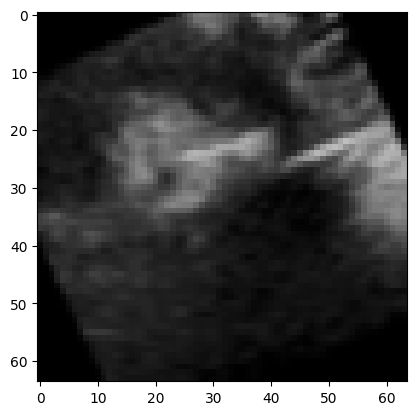

HR shape:  torch.Size([3, 256, 256])


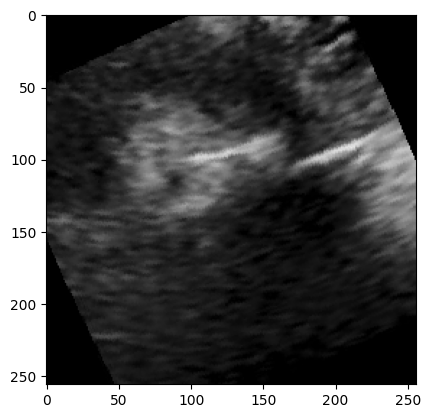

In [10]:
print('LR shape: ', inputs[0][0].shape)
plt.imshow(inputs[0][1].permute(1,2,0).numpy())
plt.show()
print('HR shape: ', inputs[1][0].shape)
plt.imshow(inputs[1][1].permute(1,2,0).numpy())
plt.show()

In [11]:
class RWMAB(nn.Module):
    """
    This class implements the Residual Whole Map Attention Network (RWMAN),
    a modification of RCAN for extracting features from low-resolution (LR) images
    and feeding them into a generator for image upscaling.
    """

    def __init__(self, input_shape: int = 64) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        )
        self.attention = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_out = self.conv1(x)
        attention = self.attention(x_out)
        x_out = torch.mul(x_out, attention) + x
        return x_out

class ShortResidualConnection(nn.Module):
    def __init__(self, input_shape: int = 64) -> None:
        super().__init__()
        RWMAN = []
        for _ in range(16):
            RWMAN.append(RWMAB())
        
        self.src = nn.Sequential(*RWMAN, 
                            nn.Conv2d(64, 64, kernel_size=1, stride=1))

    def forward(self, x):
        x_1 = self.src(x)
        return x_1 + x


class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
    
        self.conv_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.lrc = []
        for _ in range(8):
            self.lrc.append(ShortResidualConnection())
        self.conv_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.lrc = nn.Sequential(*self.lrc, self.conv_2)
        
        upsample_1 = nn.Sequential(nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                                  nn.PixelShuffle(2),
                                  nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                                  nn.PixelShuffle(2))
        conv_3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
                            
        self.upscaler = nn.Sequential(upsample_1, conv_3)
                            
    def forward(self, x):
        x_1 = self.conv_1(x)   
        x_2 = self.lrc(x_1)
        x_out = x_1 + x_2
        return self.upscaler(x_out)

In [12]:
class DBlock(nn.Module):
    
    def __init__(self, input_shape: int = 64,
                 output_shape: int = 64,
                 stride: int = 2,
                 bn: bool = True,
                 padding: int = 1) -> None:
        super().__init__()
        self.bntrue = bn
        self.conv_1 = nn.Conv2d(input_shape, output_shape, kernel_size=3, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(num_features=output_shape)
        self.leakyr = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        if self.bn == True:
            return self.leakyr(self.bn(self.conv_1(x)))
        else:
            return self.leakyr(self.conv_1(x))

class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block_1_sr = nn.Sequential(DBlock(3, 64, stride=1, bn=False),
                                DBlock(64, 64, stride=2))
        self.block_2_sr = nn.Sequential(DBlock(64, 128, stride=1),
                                DBlock(128, 128, stride=2))
        self.block_1_lr = nn.Sequential(DBlock(3, 64, stride=1, bn=False),
                                DBlock(64, 128, stride=1, bn=True))
        
        self.block_1 = nn.Sequential(DBlock(128, 256, stride=1),
                                DBlock(256, 256, stride=2))
        self.block_2 = nn.Sequential(DBlock(256, 512, stride=1),
                                DBlock(512, 512, stride=2))
        self.block_3 = nn.Sequential(DBlock(512, 1024, stride=1),
                                DBlock(1024, 1024, stride=2))
        
        self.final = nn.Sequential(nn.Linear(1024*8*8,1000),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(1000,100),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(100, 1),
                                  nn.Sigmoid())
        
    def forward(self, y, x):
        x_1 = self.block_1_sr(x)
        x_2 = self.block_2_sr(x_1)
        y_1 = self.block_1_lr(y)
        xy = torch.add(x_2, y_1)
        xy_1 = self.block_1(xy)
        xy_2 = self.block_2(xy_1)
        xy_3 = self.block_3(xy_2)
        xy_3 = xy_3.view(xy_3.size(0), -1)
        final = self.final(xy_3)
        
        return (x_1, x_2, xy_1, xy_2, xy_3, final)

In [13]:
class GeneratorLossFunction(nn.Module):
    def __init__(self, device: str = 'cuda', lambda1: float = 4e-2, lambda2: float = 1e-4,
                 vgg_layers: list[int] = [2, 7, 16, 25, 34],
                 weights: list[float] = [1/2, 1/2, 1/4, 1/16, 1/32]) -> None:
        
        super().__init__()
        
        self.vgg = models.vgg19(pretrained=True).features.to(device).eval()
        
        self.layers = vgg_layers
        self.weights = weights
        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()
        self.lambda1 = lambda1
        self.lambda2 = lambda2

            
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, discriminator, LR, HR, SR):
        return self.content_loss(HR, SR) + \
    self.lambda1 * self.adversarial_loss(discriminator, LR, HR, SR) + \
    self.lambda2 * self.adversarial_feature_loss(discriminator, LR, HR, SR)

    def vgg_extract(self, x):
        layers_output = []
        for layer in self.vgg:
            x = layer(x)
            layers_output.append(x)

        features = [layers_output[layer] for layer in self.layers]
        return features
    
    def content_loss(self, HR, SR, lambda_l1=0.2):
        HR_features = self.vgg_extract(HR)
        SR_features = self.vgg_extract(SR)
        
        loss = 0.0
        for i in range(len(self.layers)):
            loss += self.weights[i] * self.mse_loss(SR_features[i], HR_features[i])
        
        l1_loss = self.l1_loss(HR, SR)
        content_loss = lambda_l1 * l1_loss + loss
        
        return content_loss.mean()
        
        
    def adversarial_loss(self, discriminator, lr, hr, sr):
        """
        Compute the adversarial loss for the generator.
        """
        # Get discriminator outputs for real and fake images
        d_real = discriminator(lr, hr)[-1]
        d_fake = discriminator(lr, sr)[-1]
        
        # Stabilize log operations to avoid NaNs
        epsilon = 1e-8
        d_real = torch.clamp(d_real, min=epsilon, max=1 - epsilon)
        d_fake = torch.clamp(d_fake, min=epsilon, max=1 - epsilon)
        
        # Compute adversarial loss
        adv_loss = -torch.log(1 - d_real) - torch.log(d_fake)
        return adv_loss.mean()
        
        
    def adversarial_feature_loss(self, discriminator, lr, hr, sr):
        """
        Compute the adversarial feature loss for the generator.
        """

        weights = [1/2, 1/2, 1/4, 1/16, 1/32]

        d_real = discriminator(lr, hr)
        d_fake = discriminator(lr, sr)

        advfeat = 0
        for idx in range(len(weights)):
            advfeat += weights[idx] *  self.mse_loss(d_real[idx], d_fake[idx])

        return advfeat.mean()

In [14]:
class DiscriminatorLossFunction(nn.Module):
    def __init__(self, device: str = 'cuda'):
        super().__init__()
        
    def forward(lr, hr, sr):
        loss = -1*torch.log(hr) - torch.log(1-sr)
        return loss

In [15]:
class Trainer(nn.Module):
    
    def __init__(self, generator: nn.Module = None, discriminator: nn.Module = None,
                 g_loss: nn.Module = None, d_loss: nn.Module = None,
                 batch_size: int = 4, dataloader: DataLoader = None,
                 mean: tuple[float, float, float] = (0.5, 0.5, 0.5),
                 std: tuple[float, float, float] = (0.5, 0.5, 0.5),
                 device: str = 'cuda',
                 model_logs_dir: str = 'model_logs',
                 outputs_dir: str = 'output_images') -> None:
        super().__init__()
        
                
        now = datetime.now()
        output_name =  f'Month{now.month}_Day{now.day}_Hour{now.hour}'
        
        self.model_save_dir = os.path.join(model_logs_dir, output_name)
        self.image_output_dir = os.path.join(outputs_dir, output_name)
        os.makedirs(self.model_save_dir, exist_ok=True)
        os.makedirs(self.image_output_dir, exist_ok=True)
        
        self.generator = generator
        self.discriminator = discriminator
        self.dataloader = dataloader
        self.mean =  torch.tensor(mean).view(1, 3, 1, 1)
        self.std = torch.tensor(std).view(1, 3, 1, 1)
        self.g_loss = g_loss
        self.d_loss = d_loss
        self.device = device
        
    def denorm(self, img_tensor: torch.Tensor) -> torch.Tensor:
        return img_tensor * self.std + self.mean
    
    def save_samples(self, low_res_images: torch.Tensor, index: int = 0) -> None:
        self.generator.eval()
        low_res_images = low_res_images[0].to(self.device)

        with torch.no_grad():
            super_res_images = self.generator(low_res_images)
            
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(low_res_images.permute(1, 2, 0).cpu().numpy())
        ax[0].axis('off')
        ax[1].imshow(super_res_images.permute(1, 2, 0).cpu().numpy())
        ax[1].axis('off')
        plt.show()
        
        plt.savefig(os.path.join(self.image_output_dir,f'output_image_{index:04d}.png'), bbox_inches='tight', pad_inches=0.1)
        print(f'Saving Sample Epoch: {index:04d}')


            
    def save_model(self, epoch):
        gen_path = os.path.join(self.model_save_dir, f'generator_epoch_{epoch}.pth')
        disc_path = os.path.join(self.model_save_dir, f'discriminator_epoch_{epoch}.pth')
        
        torch.save(self.generator, gen_path)
        
        torch.save(self.discriminator, disc_path)
        
        print(f"Models saved at epoch {epoch}")
        
    def train_discriminator(self, lr_image, hr_image, opt_d):
        opt_d.zero_grad()

        hr_preds = self.discriminator(lr_image, hr_image)[-1]
        hr_targets = torch.ones(lr_image.size(0), 1, device=self.device)
        real_loss = F.binary_cross_entropy(hr_preds, hr_targets)
        real_score = hr_preds.mean()
        
        sr_image = self.generator(lr_image)
        sr_targets = torch.zeros(lr_image.size(0), 1, device=self.device)
        sr_preds = self.discriminator(lr_image, sr_image)[-1]
        fake_loss = F.binary_cross_entropy(sr_preds, sr_targets)
        fake_score = sr_preds.mean()

        loss = real_loss + fake_loss
        loss.backward()
        opt_d.step()

        return loss.item(), real_score, fake_score

    def train_generator(self, lr_image, hr_image, opt_g):
        opt_g.zero_grad()
        
        sr_image = self.generator(lr_image)

        preds = self.discriminator(lr_image, sr_image)[-1]
        targets = torch.ones(lr_image.size(0), 1, device=self.device)
        loss = self.g_loss(self.discriminator, lr_image, hr_image, sr_image)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.generator.parameters(), max_norm=1.0)
        opt_g.step()

        return loss.item()
    
    
    def fit(self, epochs: int = 10, learning_rate: float = 1e-5, beta: tuple[float, float] = (0.95, 0.999), start_idx=1):
        torch.cuda.empty_cache()

        losses_g = []
        losses_d = []
        real_scores = []
        fake_scores = []

        opt_d = optim.Adam(self.discriminator.parameters(), lr=learning_rate, betas=beta)
        opt_g = optim.Adam(self.generator.parameters(), lr=learning_rate, betas=beta)

        for epoch in range(epochs):
            for real_images in tqdm.tqdm(self.dataloader):
                lr_image, hr_image = real_images[0].to(self.device), real_images[1].to(self.device)
                loss_d, real_score, fake_score = self.train_discriminator(lr_image, hr_image, opt_d)
                loss_g = self.train_generator(lr_image, hr_image, opt_g)

            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))
            
            self.save_samples(lr_image ,epoch + start_idx)
            
            if epoch % 5 == 0:
                self.save_model(epoch)

        return losses_g, losses_d, real_scores, fake_scores

In [16]:
generator = Generator().to('cuda')
discriminator = Discriminator().to('cuda')

gen_loss = GeneratorLossFunction()
dis_loss = DiscriminatorLossFunction()


trainer = Trainer(generator, discriminator, gen_loss, dis_loss, dataloader=dataloader)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 187MB/s] 


100%|██████████| 235/235 [04:32<00:00,  1.16s/it]

Epoch [1/20], loss_g: 0.4198, loss_d: 1.3068, real_score: 0.5023, fake_score: 0.4552


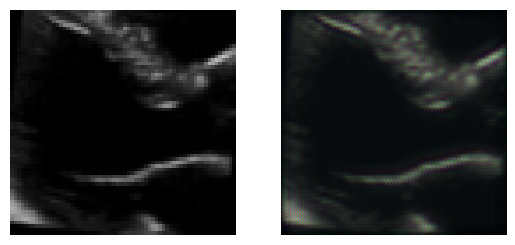

Saving Sample Epoch: 0001
Models saved at epoch 0


100%|██████████| 235/235 [04:26<00:00,  1.14s/it]

Epoch [2/20], loss_g: 0.4058, loss_d: 1.3252, real_score: 0.5044, fake_score: 0.4731


<Figure size 640x480 with 0 Axes>

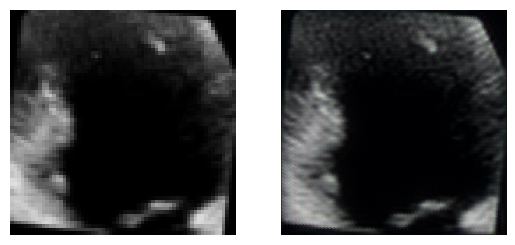

Saving Sample Epoch: 0002


100%|██████████| 235/235 [04:27<00:00,  1.14s/it]

Epoch [3/20], loss_g: 0.3754, loss_d: 1.3283, real_score: 0.4839, fake_score: 0.4520


<Figure size 640x480 with 0 Axes>

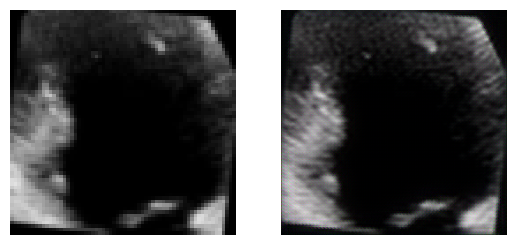

Saving Sample Epoch: 0003


100%|██████████| 235/235 [04:27<00:00,  1.14s/it]

Epoch [4/20], loss_g: 0.3545, loss_d: 1.3882, real_score: 0.4938, fake_score: 0.4947


<Figure size 640x480 with 0 Axes>

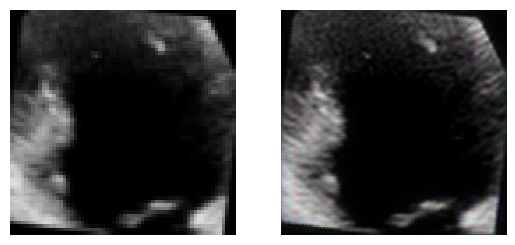

Saving Sample Epoch: 0004


100%|██████████| 235/235 [04:28<00:00,  1.14s/it]

Epoch [5/20], loss_g: 0.3395, loss_d: 1.4147, real_score: 0.4401, fake_score: 0.4478


<Figure size 640x480 with 0 Axes>

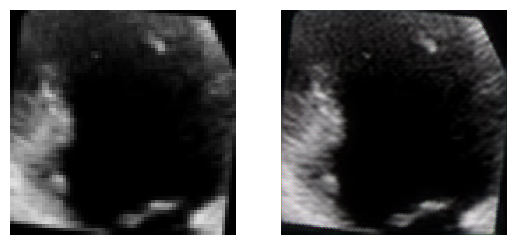

Saving Sample Epoch: 0005


100%|██████████| 235/235 [04:28<00:00,  1.14s/it]

Epoch [6/20], loss_g: 0.3283, loss_d: 1.3830, real_score: 0.5266, fake_score: 0.5236


<Figure size 640x480 with 0 Axes>

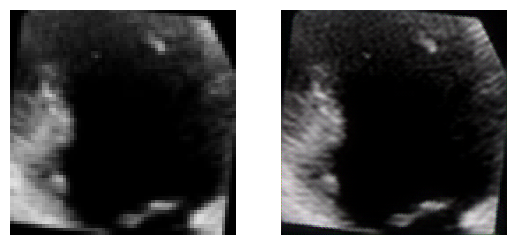

Saving Sample Epoch: 0006
Models saved at epoch 5


100%|██████████| 235/235 [04:28<00:00,  1.14s/it]

Epoch [7/20], loss_g: 0.3208, loss_d: 1.3802, real_score: 0.4793, fake_score: 0.4752


<Figure size 640x480 with 0 Axes>

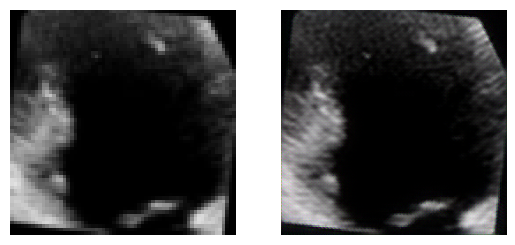

Saving Sample Epoch: 0007


100%|██████████| 235/235 [04:28<00:00,  1.14s/it]

Epoch [8/20], loss_g: 0.3136, loss_d: 1.3747, real_score: 0.4929, fake_score: 0.4868


<Figure size 640x480 with 0 Axes>

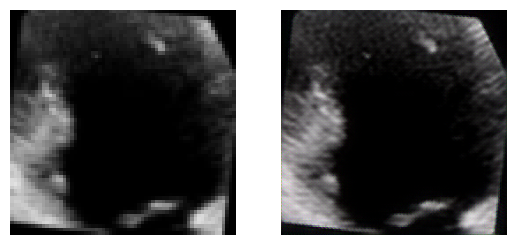

Saving Sample Epoch: 0008


100%|██████████| 235/235 [04:27<00:00,  1.14s/it]

Epoch [9/20], loss_g: 0.3086, loss_d: 1.3834, real_score: 0.5194, fake_score: 0.5171


<Figure size 640x480 with 0 Axes>

In [ ]:
losses_g, losses_d, real_scores, fake_scores = trainer.fit(epochs=20)

In [ ]:
class StudentShortResidualConnection(nn.Module):
    def __init__(self, input_shape: int = 8) -> None:
        super().__init__()
        RWMAN = []
        for _ in range(8):
            RWMAN.append(RWMAB())
        
        self.src = nn.Sequential(*RWMAN, 
                            nn.Conv2d(64, 64, kernel_size=1, stride=1))

    def forward(self, x):
        x_1 = self.src(x)
        return x_1 + x
    
class StudentGenerator(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.conv_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.lrc = []
        for _ in range(4):
            self.lrc.append(StudentShortResidualConnection())
        self.conv_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.lrc = nn.Sequential(*self.lrc, self.conv_2)
        
        upsample_1 = nn.Sequential(nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                                  nn.PixelShuffle(2),
                                  nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                                  nn.PixelShuffle(2))
        conv_3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
                            
        self.upscaler = nn.Sequential(upsample_1, conv_3)
                            
    def forward(self, x):
        x_1 = self.conv_1(x)   
        x_2 = self.lrc(x_1)
        x_out = x_1 + x_2
        return self.upscaler(x_out)
    

class StudentDiscriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block_1_sr = nn.Sequential(DBlock(3, 32, stride=1, bn=False),
                                DBlock(32, 32, stride=2))
        self.block_2_sr = nn.Sequential(DBlock(32, 64, stride=1),
                                DBlock(64, 64, stride=2))
        self.block_1_lr = nn.Sequential(DBlock(3, 32, stride=1, bn=False),
                                DBlock(32, 64, stride=1, bn=True))
        
        self.block_1 = nn.Sequential(DBlock(64, 128, stride=1),
                                DBlock(128, 128, stride=2))
        self.block_2 = nn.Sequential(DBlock(128, 256, stride=1),
                                DBlock(256, 256, stride=2))
        self.block_3 = nn.Sequential(DBlock(256, 512, stride=1),
                                DBlock(512, 512, stride=2))
        
        self.final = nn.Sequential(nn.Linear(512*8*8,1000),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(1000,100),
                                  nn.LeakyReLU(0.2),
                                  nn.Linear(100, 1),
                                  nn.Sigmoid())
        
    def forward(self, y, x):
        x_1 = self.block_1_sr(x)
        x_2 = self.block_2_sr(x_1)
        y_1 = self.block_1_lr(y)
        xy = torch.add(x_2, y_1)
        xy_1 = self.block_1(xy)
        xy_2 = self.block_2(xy_1)
        xy_3 = self.block_3(xy_2)
        xy_3 = xy_3.view(xy_3.size(0), -1)
        final = self.final(xy_3)
        
        return (x_1, x_2, xy_1, xy_2, xy_3, final)
    

In [ ]:
generator.load_state_dict(torch.load('/kaggle/working/model_logs/Month8_Day29_Hour15/generator_epoch_10.pth')['model_state_dict'])

In [ ]:
def test(image, transform=True):
    if transform==True:
        transform = transforms.Compose([
        transforms.Resize((256, 256)), 
        transforms.ToTensor(),          
        ])
        input_tensor = transform(image)
        
    input_batch = image.unsqueeze(0) 
    model = generator
    model.eval() 
    with torch.no_grad():
        output = model(input_batch.to('cuda'))
        output = model(output.to('cuda'))
    plt.imshow(input_batch.squeeze(0).cpu().permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()
    plt.imshow(output.squeeze(0).cpu().permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()
    
    

test_1 = inputs[1][0]
test_2 = inputs[0][0]

test(test_2, False)
test(test_1, False)

In [91]:
import gc
torch.cuda.empty_cache()
gc.collect()

35523